# A Pymc3 Prototype: Fitting 2D Poisson Images with Arbitrary Model Binning and PSF convolution
This propotype uses the MCMC package Pymc3 to fit images of sources that are best represented by a Poisson model. Pymc3 has several advantages with respect to existing MCMC approaches: 

* It allows for a straightforward definitions of priors with pre-computed probability distributions.
* Optimization is also straightforward, and can be donde with several methods. Pymc3 uses by default the BFGS algorithm for optimization, but other options are Powell, Newton, etc.
* Sampling is extremely flexible, and the user does not need to think a lot about fine-tuning the parameters. For example, the sampling method used is chosen automatically by Pymc3 according to the distribution to sample, as well as the proposal distribution, etc.
* Pymc3 is written for tensors and allows automatic differentiation, which means that if the target distribution can be expressed as a tensor, Pymc3 can use gradient-based methods for samplong, which are extremely efficient (NUTS, Hamiltonian MC, etc)

## Fitting Chandra images
The example below shows how a fit for a particularly difficult source from the CSC2 catalog (acisf02594_001N999_r0005b), that has only a few counts. The goal is to derive posterior probability distributions for the parameters of a Gaussian model that has been previously convolved with the corresponding PSF, and to which a background model has been added. The model and the data do not need to be defined in the same grid, but the model and the PSF should be, in order to perform the convolution.

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
from scipy.misc import factorial
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as T
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import CustomKernel

Populating the interactive namespace from numpy and matplotlib


### Binning
Below are two possible approaches for rebinning of the model grid. The idea is that the model can be defined in any arbitrary grid (supposedly the grid tha matches the resolution of the PSF model), but in order to calculate a statistic for the fit, it has to be compared with the data at the same resolution as the data. The first function (*rebin_int*) bins the model grid by summing an integer number of pixels. The second fucntion (*rebin_flux*) bins the data to mach a specific new size of the image (in pixels), while conserving the total flux.

In [2]:
def rebin_int(array,factorx,factory):
    xedge = np.shape(array)[0]%factorx
    yedge = np.shape(array)[1]%factory
    array_binned1 = array[xedge:,yedge:]

    binim = np.reshape(array_binned1,
                       (np.shape(array_binned1)[0]//factorx,factorx,np.shape(array_binned1)[1]//factory,factory))
    binim = np.sum(binim,axis=3)
    binim = np.sum(binim,axis=1)

    return binim

### PSF
The model of the PSF for this particular observation. The PSF is different for each observation. The resolution of the PSF sets the maximum resolution at which we can still get information from the model, and thus the model should be binned at the PSF resolution (also, because we need to convolve the model with the PSF). Below we read and plot the PSF.

In [3]:
# Create a Gaussian source
kernel = Gaussian2D(1, 22.0, 22.0, 6, 6)

x1 = np.arange(0,45)
y1 = np.arange(0,45)
x1, y1 = np.meshgrid(x1, y1)
psf_data = kernel(x1, y1)

(45, 45)
(45, 45)


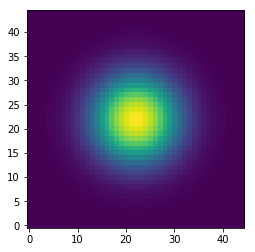

In [4]:
print(np.shape(psf_data))
plt.imshow(np.arcsinh(psf_data),origin='lower', cmap='viridis', 
           interpolation='nearest')
print (np.shape(psf_data))

In [5]:
psf_binned = rebin_int(psf_data,9,9)

Text(0.5, 1.0, 'Degraded')

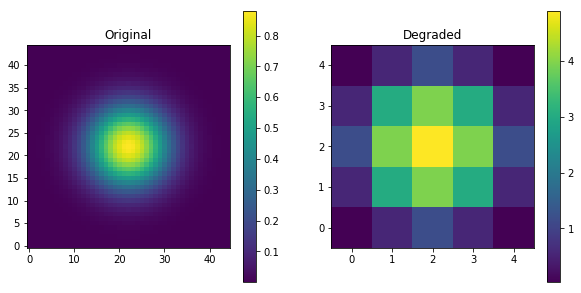

In [6]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
im = plt.imshow(np.arcsinh(psf_data),origin='lower', cmap='viridis', 
           interpolation='nearest')
cb = plt.colorbar(im)
plt.title('Original')
plt.subplot(1,2,2)
im = plt.imshow(np.arcsinh(psf_binned),origin='lower', cmap='viridis', 
           interpolation='nearest')
cb = plt.colorbar(im)
plt.title('Degraded')

# Source
Below we read and plot the counts image of the obervation, and get a cutoff that more or less matches the extent of the PSF. In this particular example the PSF and the data have the same resolution, and binning is therefore not necessary, but we will play a bit later by degrading the data to a lower resolution and see how that affects the results.

In [7]:
# Create a Gaussian source
gauss1 = Gaussian2D(10, 30.0, 30.0, 4, 4)

x = np.arange(0,45)
y = np.arange(0,45)
x, y = np.meshgrid(x, y)
img_src = gauss1(x, y)

(45, 45)


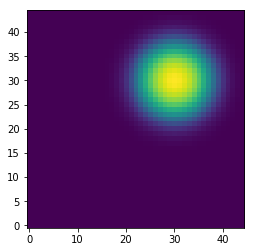

In [8]:
plt.imshow(arcsinh(img_src),origin='lower', cmap='viridis', 
           interpolation='nearest')
print (np.shape(img_src))

# Data
Now we generate the data by convolving the source with the PSF at the best possible resolution.

In [9]:
psf_kernel = CustomKernel(psf_data)
img_data = convolve_fft(img_src, psf_kernel, normalize_kernel=True)

In [10]:
data_binned = rebin_int(img_data,9,9)
print (np.shape(data_binned))

(5, 5)


Text(0.5, 1.0, 'Degraded')

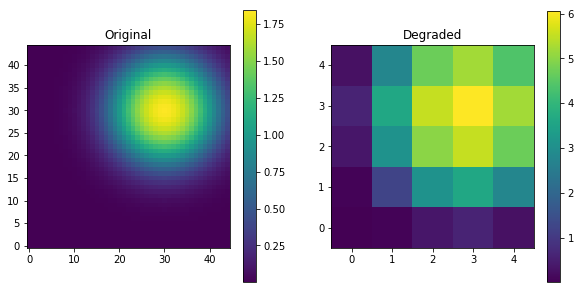

In [11]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
im = plt.imshow(np.arcsinh(img_data),origin='lower', cmap='viridis', 
           interpolation='nearest')
#plt.scatter([24.263523],[24.959832],marker='x',color='w',s=120)
#plt.scatter([24.6869],[24.8930],marker='x',color='b',s=120)
#plt.errorbar([24.263523],[24.959832], 0.46, 0.37, marker='s', ecolor='white',elinewidth=3)

#plt.xlim(20,30)
#plt.ylim(20,30)

cb = plt.colorbar(im)
plt.title('Original')
plt.subplot(1,2,2)
im = plt.imshow(np.arcsinh(data_binned),origin='lower', cmap='viridis', 
           interpolation='nearest')
#plt.scatter([24.263523/2],[24.959832/2],marker='x',color='r',s=120)
#plt.scatter([24.6869/2.],[24.8930/2.],marker='x',color='b',s=120)

cb = plt.colorbar(im)
plt.title('Degraded')

780.7911243893273


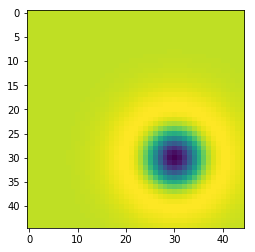

In [12]:
im = plt.imshow(img_data-img_src)
print(np.sum(np.absolute(img_data-img_src)))

### Setting up the Pymc3 model.
Below we set up the pymc3 model to perform Bayesian inference on the parameters of a Gaussian model. First we set up the grid and give it the right shape. We then define a pymc3 model (*source_mode*), and a function (*counts_func*) that defines a Gaussian object for the source on the defined grid, and returns the model source convolved with the PSF.

In [13]:
# Define the grid (This is the PSF grid, in which the convoluion happens)
#np.random.seed(2)
x0low, x0high = 0,45
x1low, x1high = 0,45
dx = 1
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [14]:
# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()
print (shape)

(45, 45)


In [15]:
from sherpa.models import Gauss2D
import theano.tensor as tt

# First let us define the pymc3 model
source_model = pm.Model()

# The function below takes the Gaussian parameters (and background) as inputs and returns
# the convolved Gaussian model, rebinned to the desired size.
@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], 
       otypes=[T.dmatrix])

def counts_func(fwhm, xpos, ypos, ampl):
    truth = Gauss2D()
    truth.ampl = ampl
    truth.xpos, truth.ypos = xpos, ypos
    truth.fwhm = fwhm
    #truth.theta = theta
    
    #  This is where we convolve and add a Poisson background
    kernel = CustomKernel(psf_data)
    astropy_conv = convolve_fft(truth(x0, x1).reshape(shape), kernel, 
                                normalize_kernel=True)
    # Now we rebin
    model_rebin = rebin_int(astropy_conv,9,9) 
    #model_rebin = astropy_conv
    
    return model_rebin
    
# Now we set the priors for the model, and define the likelihood. We can use the Poisson 
# likelihood, or alternatively, we can use the Cash statistic, defined as the log_like 
# function.
with source_model:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.01, upper=200.0)
    fwhm = BoundedNormal('fwhm', mu=5, sd=3)
    xpos = pm.Normal('xpos', mu=30., sd=5)
    ypos = pm.Normal('ypos', mu=30., sd=5)
    #ellip = BoundedNormal1('ellip', mu=0.3, sd=0.3)
    #theta = pm.Uniform('theta', lower=0.0, upper=2*np.pi)
    ampl = BoundedNormal('ampl', mu=10.0, sd=4.0)   
    #mu_bkg = pm.Uniform('mu_bkg', lower=0.0, upper=0.1)
    
    # Evaluate the model for the given parameters
    counts = counts_func(fwhm, xpos, ypos, ampl)
    
    # Mean Squared Error
    #def mse(img):    
    #    mse = sum(np.array((counts-counts*img)*2))
    #    return -mse
    
    # Cash statistic
    def cash(img):
        logpm = np.array(counts - img*np.log(counts))
        return -2.0*np.sum(logpm)
    
    # Define the likelihood. Either a Poisson likelihood or the cash model are 
    # currently possible. The parameter mu of the Poisson distribution corresponds
    # to the counts, and observed=img_binned indicates the data to which we are
    # fitting the model
    
    likelihood = pm.DensityDist("likelihood", cash, observed=data_binned)                     
    #likelihood = pm.Poisson('likelihood', mu=counts, observed=img_binned)
    #likelihood = pm.Poisson('likelihood', mu=counts, observed=data_binned)
    #likelihood = pm.Normal('likelihood', mu=counts, sd=0.01, observed=data_binned)

### Optimization and sampling
Below we perform optimization and sampling with pymc3. The *find_MAP* function finds the maximum a posteriori estimate of the model. Its result is used as an input for the sampling function *pm.sampe*. We use the Metropolis algorithms here, but we could also do Slice Sampling, or even some gradient based methods if we can turn the Sherpa functions into tensors.

In [16]:
# We can get the MAP values
map_estimate = pm.find_MAP(model=source_model, method='powell')
map_estimate

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 6,755.9: 100%|██████████| 436/436 [00:01<00:00, 224.52it/s] 


{'fwhm_interval__': array(-3.0060628),
 'xpos': array(29.99405331),
 'ypos': array(29.96591386),
 'ampl_interval__': array(-2.96183275),
 'fwhm': array(9.44007378),
 'ampl': array(9.84555483)}

In [17]:
from scipy import optimize
with source_model:
    #map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Metropolis()
    trace = pm.sample(70000,step,map_estimate,chains=2,cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [ampl]
>Metropolis: [ypos]
>Metropolis: [xpos]
>Metropolis: [fwhm]
Sampling 2 chains: 100%|██████████| 141000/141000 [31:51<00:00, 73.75draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


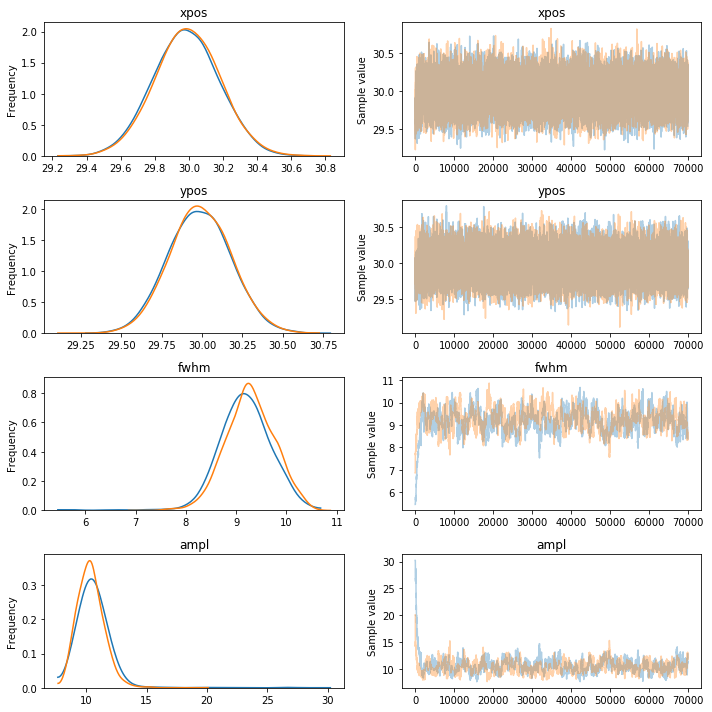

In [18]:
# Here we plot the posteriors and the traces for each paramerters. Pymc3 runs two parallel
# chanins, but if more cores are available, we can run as many as we like.
fig, axs = plt.subplots(4, 2,figsize=(10,10)) # 3 RVs
_ = pm.traceplot(trace, ax=axs)
#fig.savefig('traces4.pdf')

In [19]:
# We can get a summary of the inferred parameters, including a convergence
# diagnostic (rhat), whihc should be as close as possible to 1. Our chains 
# appear to have converged.
summary = pm.stats.summary(trace)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
xpos,29.987953,0.189867,0.002860,29.621918,30.365619,5602.250556,1.000672
ypos,29.987452,0.190062,0.002768,29.621112,30.361854,5968.252186,1.000306
fwhm,9.220898,0.513837,0.033913,8.312912,10.211051,182.570909,1.012160
ampl,10.530624,1.329704,0.089535,8.420159,12.611351,182.738361,1.012032


### Visualizing the the best-fitting model - Posterior predictive checks
Another good way to check that we have a good fitted model is by obtaining posteriror predictives. This means that we sample parameter values from the obtained posteriors, and generate data from thos samples that should look like the actual data. Below we generate 25 of those posterior predictive images, and plot them

In [ ]:
ppc = pm.sample_ppc(trace, samples=25, model=source_model)

In [ ]:
plt.subplots(5,5,figsize=(20,20))
for ind,image in enumerate(ppc['likelihood']):
    plt.subplot(5,5,ind+1)
    plt.imshow(ppc['likelihood'][ind])

Alternatively, we can also take the mean from the posteriors and plot the model corresponding to it, and compare it with the real data. Below are plots of the data, the best fitting model, an a Poisson realisation of that model.

In [ ]:
truth = Gauss2D()
truth.xpos, truth.ypos = summary['mean'].xpos,summary['mean'].ypos
truth.fwhm, truth.ellip = summary['mean'].fwhm, summary['mean'].ellip
#truth.theta, truth.ampl = summary['mean'].theta, summary['mean'].ampl
truth.ampl = summary['mean'].ampl
mexp = truth(x0, x1).reshape(shape)+np.random.poisson(summary['mean'].mu_bkg,shape)


In [ ]:
kernel = CustomKernel(psf_data)
conv_model = convolve_fft(mexp, kernel, normalize_kernel=True)
#msim = np.random.poisson(conv_model)
msim=conv_model

# Plot
plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
im = plt.imshow(np.arcsinh(data_binned), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
#plt.scatter([7.772044+0.5],[7.967980+0.5],marker='x',color='r')
plt.title('Data image')
plt.subplot(1,3,2)
im = plt.imshow(np.arcsinh(conv_model), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
plt.title('Model image')
plt.subplot(1,3,3)
im = plt.imshow(np.arcsinh(msim), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
plt.title('Model realisation')
#plt.savefig('PG1634_m6.png')

### Lower resolution data
We now degrade the data to have a lower resolution and attempt the fit again to see the effect on the derived parameters

In [ ]:
img_binned = rebin_flux(img_data,(10,10))

In [ ]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
im = plt.imshow(img_binned1,origin='lower', cmap='viridis', 
           interpolation='nearest')
cb = plt.colorbar(im)
plt.title('Original')
plt.subplot(1,2,2)
im = plt.imshow(img_binned,origin='lower', cmap='viridis', 
           interpolation='nearest')
cb = plt.colorbar(im)
plt.title('Degraded')

We use the same model, but make sure to use the proper binnig for the model. The model is still evaluated in the "high resolution" grid, and is rebinned only afterwards for comparison.

In [ ]:
from sherpa.models import Gauss2D
import theano.tensor as tt

# First let us define the pymc3 model
source_model = pm.Model()

# The function below takes the Gaussian parameters (and background) as inputs and returns
# the convolved Gaussian model, rebinned to the desired size.
@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar,  T.dscalar], otypes=[T.dmatrix])

def counts_func(fwhm, xpos, ypos, ellip, theta, ampl, mu_bkg):
    truth = Gauss2D()
    truth.ampl = ampl
    truth.xpos, truth.ypos = xpos, ypos
    truth.fwhm, truth.ellip = fwhm, ellip
    truth.theta = theta
    kernel = CustomKernel(psf_data)
    astropy_conv = convolve_fft(truth(x0, x1).reshape(shape)+mu_bkg*np.ones(shape), kernel, normalize_kernel=True)
    model_rebin = rebin_flux(astropy_conv,(10,10)) 
    
    return model_rebin
    
# Now we set the priors for the model, and define the likelihood. We can use the Poisson 
# likelihood, or alternatively, we can use the Cash statistic, defined as the log_like 
# function.
with source_model:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=10.0)
    BoundedNormal1 = pm.Bound(pm.Normal, lower=0.0, upper=0.99)
    fwhm = BoundedNormal('fwhm', mu=2.1, sd=1.5)
    xpos = pm.Normal('xpos', mu=10.0, sd=3.0)
    ypos = pm.Normal('ypos', mu=10.0, sd=3.0)
    ellip = BoundedNormal1('ellip', mu=0.3, sd=0.3)
    theta = pm.Uniform('theta', lower=0.0, upper=2*np.pi)
    ampl = BoundedNormal('ampl', mu=0.3, sd=0.3)   
    mu_bkg = pm.Uniform('mu_bkg', lower=0.0, upper=0.01)
    
    # Evaluate the model for the given parameters
    counts = counts_func(fwhm, xpos, ypos, ellip, theta, ampl, mu_bkg)
    
    # Cash statistic
    def log_like(img):
        logpm = np.array(counts - img*np.log(counts))
        return -2.0*np.sum(logpm)
    
    # Define the likelihood. Either a Poisson likelihood or the cash model are 
    # currently possible. The parameter mu of the Poisson distribution corresponds
    # to the counts, and observed=img_binned indicates the data to which we are
    # fitting the model
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=img_binned)                     
    likelihood = pm.Poisson('likelihood', mu=counts, observed=img_binned)

And now we sample

In [ ]:
from scipy import optimize
with source_model:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Metropolis()
    trace = pm.sample(2000,step,map_estimate)

In [ ]:
# Here we plot the posteriors and the traces for each paramerters. Pymc3 runs two parallel
# chanins, but if more cores are available, we can run as many as we like.
fig, axs = plt.subplots(7, 2,figsize=(10,10)) # 3 RVs
_ = pm.traceplot(trace, ax=axs)
#fig.savefig('traces4.pdf')

The good news is that the posteriors do not look much different from the original version. Let's look at the summary:

In [ ]:
# We can get a summary of the inferred parameters, including a convergence
# diagnostic (rhat), whihc should be as close as possible to 1. Our chains 
# appear to have converged.
summary = pm.stats.summary(trace)
summary

The uncertainties in position and width are a bit larger. The uncertainty in amplitude is same as before.

## Comparison with Sherpa MCMC
We now perform the same fit using the Sherpa implementation of MCMC (but without the binning part, which is currently not part of Sherpa). Sherpa provides a Markov Chain Monte Carlo (MCMC) method designed for Poisson-distributed data. It was originally developed as the Bayesian Low-Count X-ray Spectral (BLoCXS) package, but has since been incorporated into Sherpa. It is developed from the work presented in Analysis of Energy Spectra with Low Photon Counts via Bayesian Posterior Simulation by van Dyk et al.

In [ ]:
# Let us first load the image data into Sherpa
from sherpa.astro import ui
import numpy as np
ui.load_image('acisf02594_001N999_r0005b_ctsimg3.fits')

In [ ]:
# Let us now load the PSF and resize crop it a bit
ui.load_psf('psf0','acisf02594_001N999_r0005b_psf3.fits')
psf0.size = [21,21]
psf0.center = [24,27]

In [ ]:
# We set the model PSF to the one we have loaded
ui.set_psf('psf0')

In [ ]:
print(ui.get_psf())

In [ ]:
# We now set a Gaussian source model with a constant background and thaw ellipticity 
# and rotation angle. We also set the limits for background
ui.set_source(ui.gauss2d.mdl)
#ui.set_source(mdl + ui.const2d.bgmdl)
mdl.ellip.thaw()
mdl.theta.thaw()

In [ ]:
# Here we set the statistic to the Cash statisitc, and the optimization method to Simplex.
ui.set_stat('cash')
ui.set_method('simplex')

In [ ]:
# We want the value in each pixel to be read at the center
#bgmdl.integrate = False

In [ ]:
# Let us fit, by finding a MAP estimate. First, we have sherpa guessing initial values
ui.guess(mdl)
ui.fit()

In [ ]:
# Let us fit again, just in case the optimizer got stuck
ui.fit()

In [ ]:
# We now print the model
print(ui.get_source())

In [ ]:
# Let us add background
ui.set_source(mdl + ui.const2d.bgmdl)
bgmdl.c0.min = 0.0
bgmdl.c0.max = 0.01
bgmdl.c0.val = 0.005

In [ ]:
print(ui.get_source())

In [ ]:
# We want the value in each pixel to be read at the center
bgmdl.integrate = False

In [ ]:
# Fit
ui.fit()

In [ ]:
# Do it again
ui.fit()

In [ ]:
# We now run 'conf' to find the errors
ui.conf()

In [ ]:
# Get the results from conf
conf = ui.get_conf_results()

In [ ]:
# Get the maxima of each parameter 
conf_err = np.array(ui.get_conf_results().parmaxes)
conf_err

In [ ]:
# We define the covar matrix with the erros from covar as diagonals
cvmat = np.diag(conf_err*conf_err)

In [ ]:
# Now we run MCMCM
draws = ui.get_draws(niter=2000, covar_matrix=cvmat)

In [ ]:
svals, accept, pvals = draws

In [ ]:
# Acceptance rate
accept.sum() * 1.0 / 1000

In [ ]:
import matplotlib.pyplot as plt
# Now let us plot the traces
plt.subplots(3,3,figsize=(10,10))
plt.subplot(3,3,1)
plt.plot(pvals[0, :])
plt.xlabel('Iteration')
plt.ylabel('fwhm')
plt.subplot(3,3,2)
plt.plot(pvals[1, :])
plt.xlabel('Iteration')
plt.ylabel('xpos')
plt.subplot(3,3,3)
plt.plot(pvals[2, :])
plt.xlabel('Iteration')
plt.ylabel('ypos')
plt.subplot(3,3,4)
plt.plot(pvals[3, :])
plt.xlabel('Iteration')
plt.ylabel('ellip')
plt.subplot(3,3,5)
plt.plot(pvals[4, :])
plt.xlabel('Iteration')
plt.ylabel('theta')
plt.subplot(3,3,6)
plt.plot(pvals[5, :])
plt.xlabel('Iteration')
plt.ylabel('ampl')
plt.subplot(3,3,7)
plt.plot(pvals[6, :])
plt.xlabel('Iteration')
plt.ylabel('bkg')

It appears to me that Sherpa get_draws fails to converge here. With only a few counts available, and seven parameters at play, this approach does not seem to be very robust, at least in its default version. Perhaps someone can play with this code and help it converge?